Team Members
- Yutian Wang 85994168
- Ronin Cunningham 43949676
- Prayus Shrestha 55823454
- Ebin Tomy 44912301

# Weather Impacts on US Corn Prices

TO-DO: opening paragraph.  This study focuses on the relationship between weather and corn prices in US...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
%matplotlib inline

TO-DO: incorporate Prayus' data scrapping section here

TO-DO: add description for these two data sets. source? meaning of each column? 

### Data Cleaning and Formatting

In [2]:
weather_data = pd.read_csv('../data/weather_data.csv')
weather_data.head()

,Unnamed: 0,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum
0,0,2000-03-24,12.6,-6.6,5.7,0.0
1,1,2000-03-25,15.0,-1.0,8.7,0.0
2,2,2000-03-26,18.7,2.4,11.2,0.0
3,3,2000-03-27,22.9,1.5,14.8,0.0
4,4,2000-03-28,22.8,7.2,14.8,0.0


In [3]:
weather_data = weather_data[['time','temperature_2m_mean','precipitation_sum']]
weather_data['weather_date'] = pd.to_datetime(weather_data['time'])
weather_data = weather_data.set_index('weather_date')
weather_data.head()

,time,temperature_2m_mean,precipitation_sum
weather_date,,,
2000-03-24,2000-03-24,5.7,0.0
2000-03-25,2000-03-25,8.7,0.0
2000-03-26,2000-03-26,11.2,0.0
2000-03-27,2000-03-27,14.8,0.0
2000-03-28,2000-03-28,14.8,0.0


In [4]:
corn_data = pd.read_csv('../data/corn_data.csv', index_col = 0)
corn_data.head()

,open,close,high,low
2023-04-20,636.50,626.50,637.25,622.00
2023-04-19,675.75,672.25,680.00,671.00
2023-04-18,676.00,677.50,682.50,669.75
2023-04-17,666.00,676.50,677.00,662.25
2023-04-16,635.00,634.75,635.75,634.00


In [5]:
corn_data.index = pd.to_datetime(corn_data.index)
corn_data.index.name = 'corn_price_date'
corn_data['avg_price'] = (corn_data['high'] + corn_data['low'])/2
corn_data = corn_data[['avg_price']]
corn_data = corn_data.sort_index()
corn_data = corn_data.dropna() # drop missing values
corn_data.head()

,avg_price
corn_price_date,
2018-04-23,377.750
2018-04-24,379.250
2018-04-25,383.875
2018-04-26,385.500
2018-04-27,387.875


It's important to consider the time lag between the weather and corn price data. We should account for the fact that weather conditions in a given year may affect the corn harvest and therefore corn prices in the following year. So we shift the index of corn_data backwards by 365 days and create a new column called 'shifted_price_date' with the shifted index values, then to merge the two dataframes.

In [6]:
corn_data['shifted_price_date'] = corn_data.index - pd.DateOffset(years=1)
corn_data = corn_data.reset_index()
merged_data = pd.merge(corn_data, weather_data, left_on='shifted_price_date', right_on='weather_date')
merged_data = merged_data[['corn_price_date', 'avg_price', 'temperature_2m_mean', 'precipitation_sum']]
merged_data = merged_data.set_index('corn_price_date')
merged_data.head()

,avg_price,temperature_2m_mean,precipitation_sum
corn_price_date,,,
2018-04-23,377.750,17.2,0.0
2018-04-24,379.250,14.9,0.0
2018-04-25,383.875,16.3,0.0
2018-04-26,385.500,18.0,0.0
2018-04-27,387.875,16.0,0.0


### Data Standardization

As temperature, precipitation, and price are on different scales, we standardize them to make it easier for comparison. Variables that have large values, such as temperature or precipitation, can dominate the analysis if they are not standardized.

In [7]:
# Standardize the data
scaler = StandardScaler()
merged_data_scaled = pd.DataFrame(scaler.fit_transform(merged_data), columns=merged_data.columns, index=merged_data.index)
merged_data_scaled.head()

,avg_price,temperature_2m_mean,precipitation_sum
corn_price_date,,,
2018-04-23,-0.809717,0.481661,-0.17049
2018-04-24,-0.799452,0.309092,-0.17049
2018-04-25,-0.767800,0.414134,-0.17049
2018-04-26,-0.756680,0.541685,-0.17049
2018-04-27,-0.740426,0.391625,-0.17049


### Trial Plotting

Text(0.5, 1.0, 'Corn Average Price Overview')

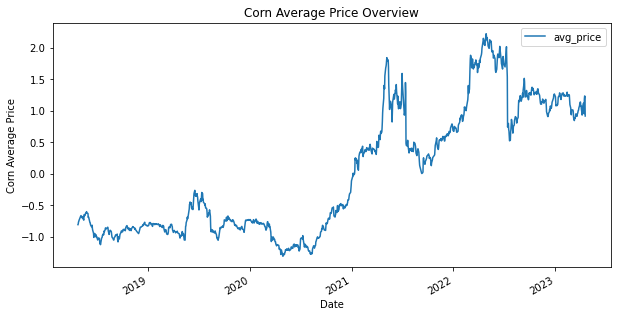

In [8]:
# plot the time-series
merged_data_scaled.plot(y='avg_price', figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Corn Average Price')
plt.title('Corn Average Price Overview')

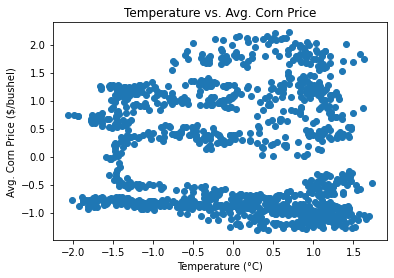

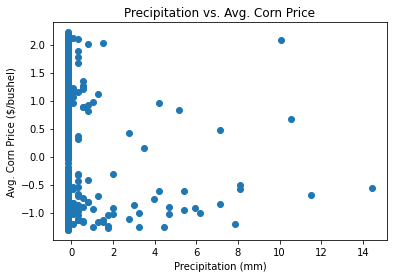

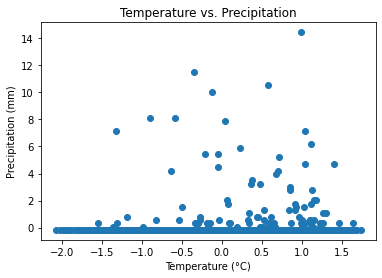

In [9]:
plt.scatter(merged_data_scaled['temperature_2m_mean'], merged_data_scaled['avg_price'])
plt.xlabel('Temperature (°C)')
plt.ylabel('Avg. Corn Price ($/bushel)')
plt.title('Temperature vs. Avg. Corn Price')
plt.show()

plt.scatter(merged_data_scaled['precipitation_sum'], merged_data_scaled['avg_price'])
plt.xlabel('Precipitation (mm)')
plt.ylabel('Avg. Corn Price ($/bushel)')
plt.title('Precipitation vs. Avg. Corn Price')
plt.show()

plt.scatter(merged_data_scaled['temperature_2m_mean'], merged_data_scaled['precipitation_sum'])
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.title('Temperature vs. Precipitation')
plt.show()

Based on the plots, there doesn't seem to be a strong correlation between temperature and precipitation with corn prices. It's also possible that the relationship between weather and corn prices is more complex than a simple linear relationship, and may require further analysis to uncover.

In [10]:
corr_matrix = merged_data_scaled[['avg_price', 'temperature_2m_mean', 'precipitation_sum']].corr()
print(corr_matrix)

                     avg_price  temperature_2m_mean  precipitation_sum
avg_price             1.000000            -0.077689          -0.052772
temperature_2m_mean  -0.077689             1.000000           0.053488
precipitation_sum    -0.052772             0.053488           1.000000


<AxesSubplot:>

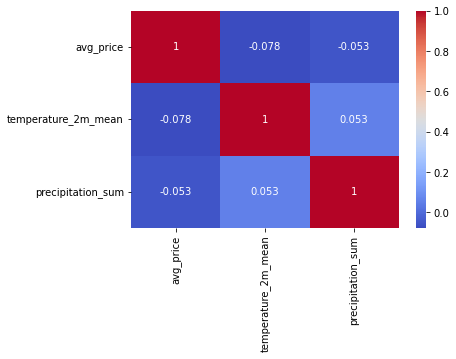

In [11]:
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

### Time Series

Using lags of 1 and 2 time periods to capture any possible autocorrelation, without overfitting the model or introducing too much noise. 

In [12]:
# create lagged variables
merged_data_scaled['temp_lag1'] = merged_data_scaled['temperature_2m_mean'].shift(1)
merged_data_scaled['temp_lag2'] = merged_data_scaled['temperature_2m_mean'].shift(2)
merged_data_scaled['precip_lag1'] = merged_data_scaled['precipitation_sum'].shift(1)
merged_data_scaled['precip_lag2'] = merged_data_scaled['precipitation_sum'].shift(2)
merged_data_scaled = merged_data_scaled.dropna()

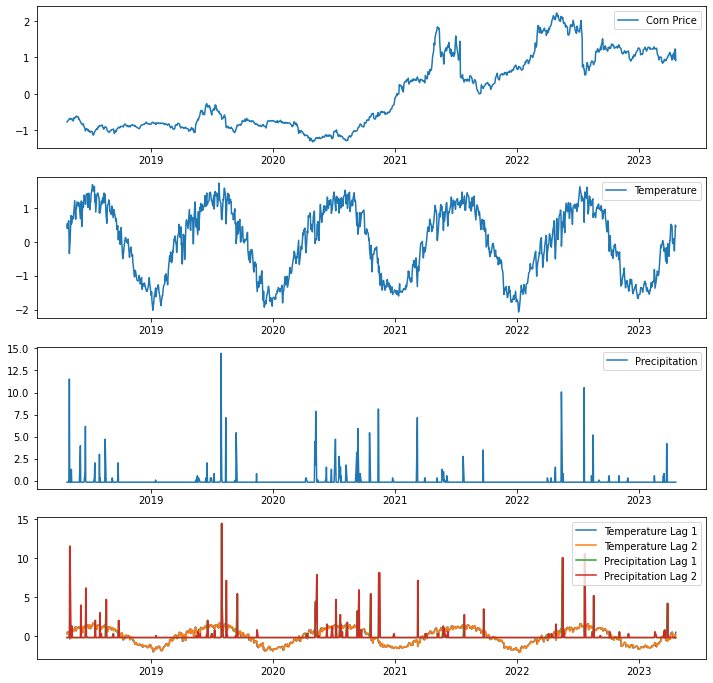

In [13]:
# Plot the merged data
fig, axs = plt.subplots(4, figsize=(12, 12))
axs[0].plot(merged_data_scaled.index, merged_data_scaled['avg_price'], label='Corn Price')
axs[0].legend()
axs[1].plot(merged_data_scaled.index, merged_data_scaled['temperature_2m_mean'], label='Temperature')
axs[1].legend()
axs[2].plot(merged_data_scaled.index, merged_data_scaled['precipitation_sum'], label='Precipitation')
axs[2].legend()
axs[3].plot(merged_data_scaled.index, merged_data_scaled['temp_lag1'], label='Temperature Lag 1')
axs[3].plot(merged_data_scaled.index, merged_data_scaled['temp_lag2'], label='Temperature Lag 2')
axs[3].plot(merged_data_scaled.index, merged_data_scaled['precip_lag1'], label='Precipitation Lag 1')
axs[3].plot(merged_data_scaled.index, merged_data_scaled['precip_lag2'], label='Precipitation Lag 2')
axs[3].legend()
plt.show()

### Linear Regression Analysis

In [14]:
X = merged_data_scaled[['temp_lag1', 'temp_lag2', 'precip_lag1', 'precip_lag2']]
y = merged_data_scaled['avg_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print('Coefficients:', lr_model.coef_)
print('Intercept:', lr_model.intercept_)

Coefficients: [ 0.08004733 -0.16066494 -0.03076128 -0.03296935]
Intercept: 0.010729332738020412


In [15]:
# make predictions on test data
y_pred = lr_model.predict(X_test)

train_rmse = np.sqrt(np.mean((lr_model.predict(X_train) - y_train) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 0.9937011380423691
Test RMSE: 0.9993322960406154


TO-DO: add some discussions here

### Cross-Validation

In [16]:
lr2 = LinearRegression()
X = merged_data_scaled.drop('avg_price', axis=1)
y = merged_data_scaled['avg_price']

mse_scores = -cross_val_score(lr2, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Average MSE: {mse_scores.mean():.4f}, Standard deviation: {mse_scores.std():.4f}")

Average MSE: 1.4625, Standard deviation: 0.6329
